Code : [github.com/ageron/handson-ml2](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb)

Books : [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)


In [1]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

try :
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

import numpy as np
import os

np.random.seed(0)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize = 14)
mpl.rc("xtick", labelsize = 12)
mpl.rc("ytick", labelsize = 12)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout = True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)


## Vanishing/Exploding Gradients Problem


gradients often get smaller and smaller as the algorithm progresses down to the lower layers.

- 결국 gradient descent update 발생하지 않음. -> training never converges to a good solution

    --> Vanishing gradient descent

- 반대로 gradients grow bigger -> training diverges

    --> Exploding gradients

activation function + weight initialization scheme 

-> the variance of the outputs of each layer >> the variance of its inputs

sigmoid function -> vanishing gradient 

In [3]:
def logit(z):
    return 1/ (1+np.exp(-z))

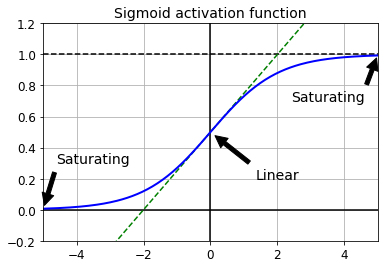

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()


## Glorot and He Initialization

Glorot and Bengio point out that we need the signal to flow properly in both directions : in the forward direction when making prediction and in reverse direction when backpropagating gradients and vice versa.

??For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction.

**Xavier initialization or Glorot initialization** -> None, tanh, logistic, softmax

the connection weights of each layer must be initialized randomly as described in Equation 11-1, where $fan_{avg}$ = $(fan_{in} + fan_{out})/2$.

_Equation 11-1. Glorot initialization (when using the logistic activation function)_

Normal distribution with mean 0 and variance $\sigma^2$ = $\cfrac{1}{fan_{avg}}$

Or a uniform distribution between $-r$ and $+r$, with $ r = \sqrt{\cfrac{3}{fan_{avg}} }$

Using Glorot initialization can speed up training considerably.

**LeCun initialization** -> SELU

replace $fan_{avg}$ with $fran_{in}$

** He initialization ** -> ReLu and ??variants

The initialization strategy for the ReLU activation function.

$ \sigma^2 = \cfrac{2}{fan_{in}}$

?? distribution이 다르면 뭐가 다른가, fan_avg와 fan_in 차이가 뭔가.

In [5]:
print([name for name in dir(keras.initializers) if not name.startswith("_")])

['Constant', 'GlorotNormal', 'GlorotUniform', 'Identity', 'Initializer', 'Ones', 'Orthogonal', 'RandomNormal', 'RandomUniform', 'TruncatedNormal', 'VarianceScaling', 'Zeros', 'constant', 'deserialize', 'get', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform', 'identity', 'lecun_normal', 'lecun_uniform', 'ones', 'orthogonal', 'serialize', 'zeros']


In [6]:
keras.layers.Dense(10, activation='relu', kernel_initializer="he_normal")
keras.layers.Dense(10, activation='selu', kernel_initializer="lecun_normal")
keras.layers.Dense(10, activation='softmax', kernel_initializer="lecun_normal")

In [7]:
init = keras.initializers.VarianceScaling(scale = 2., mode = 'fan_avg',
                                            distribution = 'uniform')
keras.layers.Dense(10, activation = 'relu', kernel_initializer=init)

## Nonsaturating Activaation Functions

The problems with unstable gradients were in part due to poor choice of activation function.

** ReLU ** = max(0,z)
- dying _ReLUs_ : they stop outputting anything other than 0.

** Leaky ReLU ** = max($\alpha z$, $z$)
- The hyperparameter $\alpha$ defines how much the function "leaks". typically set to 0.01.
- Huge leak ($\alpha = 0.2$) outperformed the small leak ($\alpha = 0.01$).

** randomized leaky ReLU **
- $\alpha$ is picked randomly in a given range during training, and is fixed to an average value during testing.
- outperformed and seemed to act as an regularizer. (reducing the risk of overfitting the training set).

** parametric leaky ReLU **
-$\alpha$ is authorized to be learned during training (becomes a parameter that can be modified by backpropagation).

** exponential linear unit (ELU) **
- outperformed all the ReLU variants.
- reduced training time
- performed better on the test set.

$ ELU_{\alpha}(z) $ = $\alpha ( exp(z) -1)$ if $z$ < 0 or $z$ if $z \ge 0$.

- It takes on negative values when z < 0, which allows the unit to have an average output closer to 0.
- It halps to alleviate the vanishing gradients.
- It has nonzero gradient for z < 0.
- It is slower to compute than ReLU and its variants

** Scaled ELU (SELU) **
- scaled variant of the ELU activation function
- self-normalized : the output of each layer will tend to preserve a mean of 0 and standard deviation of 1.
- outperforming oter activation functions.
- input must be standardized.
- weight initializer = LeCun normal initialization
- networks must be sequential.

$SELU(z) = \lambda*( \: z$ if x > 0 or $\alpha e^x - \alpha$ if $x \le 0$ )

$\alpha$ ≈ 1.6732632423543772848170429916717

λ ≈ 1.0507009873554804934193349852946



### Leaky ReLU

In [8]:
def leaky_relu(z, alpha = 0.01):
    return np.maximum(alpha*z,z)

Saving figure leaky_relu_plot


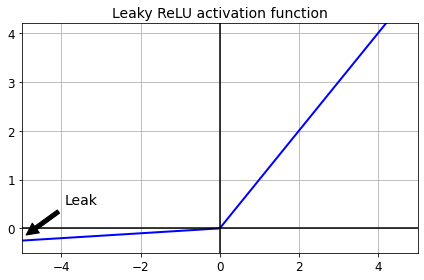

In [9]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [10]:
print([m for m in dir(keras.activations) if not m.startswith("_")])

['deserialize', 'elu', 'exponential', 'get', 'hard_sigmoid', 'linear', 'relu', 'selu', 'serialize', 'sigmoid', 'softmax', 'softplus', 'softsign', 'swish', 'tanh']


In [11]:
print([m for m in dir(keras.layers) if "relu" in m.lower()])

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']


#### Let's train a neural network on Fashion MNIST using the Leaky ReLU

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [13]:

tf.random.set_seed(0)
np.random.seed(0)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
                optimizer = keras.optimizers.SGD(lr = 1e-3),
                metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 1, validation_data = (X_valid, y_valid))

1719/1719 [==============================] - 47s 28ms/step - loss: 1.2523 - accuracy: 0.6094 - val_loss: 0.8551 - val_accuracy: 0.7230


### parametic leaky ReLU (PReLU):

In [14]:
tf.random.set_seed(0)
np.random.seed(0)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
                optimizer = keras.optimizers.SGD(lr = 1e-3),
                metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 1, validation_data = (X_valid, y_valid))

1719/1719 [==============================] - 52s 30ms/step - loss: 1.3080 - accuracy: 0.6035 - val_loss: 0.8854 - val_accuracy: 0.7184


### ELU

In [15]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

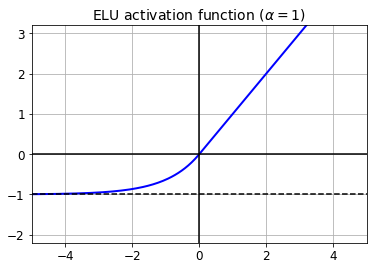

In [16]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

#### Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [17]:
keras.layers.Dense(10, activation="elu")

### SELU
This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [18]:
from scipy.special import erfc
# alpha and scale to self-normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi)/(erfc(1/np.sqrt(2)) * np.exp(1/2) -1)
scale_0_1 = (1-erfc(1/np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2+np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [19]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

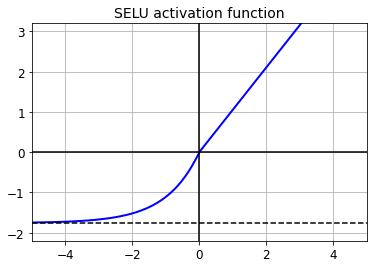

In [20]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [21]:

np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [22]:
# Using SELU is easy:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [23]:
# Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:
np.random.seed(0)
tf.random.set_seed(0)
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])
# Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = model.fit(X_train_scaled, y_train, epochs=1,
                    validation_data=(X_valid_scaled, y_valid))

# Now look at what happens if we try to use the ReLU activation function instead:


1719/1719 [==============================] - 126s 73ms/step - loss: 2.1537 - accuracy: 0.1855 - val_loss: 1.8172 - val_accuracy: 0.2880


In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=1,
                    validation_data=(X_valid_scaled, y_valid))
# Not great at all, we suffered from the vanishing/exploding gradients problem.

1719/1719 [==============================] - 165s 96ms/step - loss: 2.0844 - accuracy: 0.1700 - val_loss: 1.5313 - val_accuracy: 0.3688


## Batch Normalization

- zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer.
- evaluate the mean and standard deviation of the input over the current mini batch.

_Equation 11-3. Batch Normalization algorithm_

1. $\mu_{B}=\cfrac{1}{m_B}\sum_{i=1}^{m_B}{x^{(i)}}$

2. $ \sigma_B^2$ = $\cfrac{1}{m_B}\sum_{i=1}^{m_B}{(x^{(i)}-\mu_B)^2}$

3. $\hat{x}^{(i)}$ = $\cfrac{x^(i) - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$

4. $z^{(i)} = \gamma \bigotimes \hat{x}^{(i)} + \beta $

- $\mu_B$ : vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input)
- $\sigma_B$ : vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input)
- $m_B$ : number of instances in the mini-batch
- $\hat{x}^{(i)}$ : vector of zero-centered and normalized inputs for instance i.
- $\gamma$  : output scale parameter vector for the layer.
- $\beta$   : output shift parameter vector for the layer.
- $\epsilon$   : a tiny number that avoids division by zero. (typically $10^{-5}$}), called smoothing term.
- $z^{(i)}$ : output of the BN operation.


?? Most impelementation of Batch Normalization estimate these final statistics during training by using a moving average of the layer's input means and standard deviations.


To sum up, 
- $\gamma$(the output scale vector), $\beta$(the output offset vector) are learned throught backpropagation.
- $\mu$(the final input mean vector) and $\sigma$(the final input standard deviation) are estimated using an exponential moving average.
- ??Note, $\mu$ and $\sigma$ are estimated during training but they are used only after training.

Fianlly, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques(such as dropout)

Further, Chapter 19

In [1]:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

NameError: name 'keras' is not defined

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

In [ ]:
bn1.updates


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:

## Gradient Clipping


- mitigate the exploding gradients problem.
- clip the gradients during backpropagation so that they never exceed some threshold.
- threshold is a hyperparameter you can tune.
- clipvalue : it may change the orientation of the gradient vector.
- clipnorm : it doesn't change the orientation.
- be used often in recurrent neural networks, instead of Batch Normalization


All Keras optimizers accept clipnorm or clipvalue arguments:

In [24]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## ReUsing Pretrained Layers

### Reusing a keras model
Let's split the fashion MNIST training set in two:
- X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
- X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [4]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [6]:

print(X_train_A.shape)
print(X_train_B.shape)

print(y_train_A[:30])
print(y_train_B[:30])


(43986, 28, 28)
(200, 28, 28)
[4 0 5 7 7 7 4 4 3 4 0 1 6 3 4 3 2 6 5 3 4 5 1 3 4 2 0 6 7 1]
[1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1.]


In [7]:
tf.random.set_seed(42)
np.random.seed(42)

In [10]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300,100,50,50,50):
    model_A.add(keras.layers.Dense(n_hidden,activation='selu'))
model_A.add(keras.layers.Dense(8,activation='softmax'))

model_A.compile(loss='sparse_categorical_crossentropy',
                optimizer = keras.optimizers.SGD(lr=1e-3),
                metrics = ['accuracy'])

history = model_A.fit(X_train_A, y_train_A, epochs=2,
validation_data=(X_valid_A, y_valid_A))

Epoch 1/2
1375/1375 [==============================] - 46s 33ms/step - loss: 0.5785 - accuracy: 0.8090 - val_loss: 0.3924 - val_accuracy: 0.8587
Epoch 2/2
1375/1375 [==============================] - 45s 33ms/step - loss: 0.3607 - accuracy: 0.8766 - val_loss: 0.3316 - val_accuracy: 0.8884


In [11]:
model_A.save("my_model_A.h5")

In [12]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300,100,50,50,50):
    model_B.add(keras.layers.Dense(1, activation='sigmoid'))

model_B.compile(loss='binary_crossentropy',
                optimizer = keras.optimizers.SGD(lr=1e-3),
                metrics=['accuracy'])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                        validation_data = (X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 62ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 6/20
7/7 [==============================] - 0s 26ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 8/20
7/7 [===========

In [15]:
model_B.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 785       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 2         
Total params: 793
Trainable params: 793
Non-trainable params: 0
________________________________________________________

In [16]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [17]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [23]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss='binary_crossentropy',
                        optimizer = keras.optimizers.SGD(lr=1e-3),
                        metrics = ['accuracy'])

In [24]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 135ms/step - loss: 0.8995 - accuracy: 0.5050 - val_loss: 0.8790 - val_accuracy: 0.5274
Epoch 2/4
7/7 [==============================] - 0s 35ms/step - loss: 0.8457 - accuracy: 0.5200 - val_loss: 0.8317 - val_accuracy: 0.5497
Epoch 3/4
7/7 [==============================] - 0s 29ms/step - loss: 0.7983 - accuracy: 0.5600 - val_loss: 0.7858 - val_accuracy: 0.5649
Epoch 4/4
7/7 [==============================] - 0s 54ms/step - loss: 0.7526 - accuracy: 0.5750 - val_loss: 0.7412 - val_accuracy: 0.5933


In [25]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 121ms/step - loss: 0.5336 - accuracy: 0.7050 - val_loss: 0.3745 - val_accuracy: 0.8803
Epoch 2/16
7/7 [==============================] - 1s 168ms/step - loss: 0.3114 - accuracy: 0.9150 - val_loss: 0.2921 - val_accuracy: 0.9239
Epoch 3/16
7/7 [==============================] - 1s 152ms/step - loss: 0.2436 - accuracy: 0.9550 - val_loss: 0.2442 - val_accuracy: 0.9503
Epoch 4/16
7/7 [==============================] - 1s 114ms/step - loss: 0.2017 - accuracy: 0.9750 - val_loss: 0.2110 - val_accuracy: 0.9594
Epoch 5/16
7/7 [==============================] - 1s 121ms/step - loss: 0.1721 - accuracy: 0.9750 - val_loss: 0.1874 - val_accuracy: 0.9635
Epoch 6/16
7/7 [==============================] - 1s 100ms/step - loss: 0.1500 - accuracy: 0.9800 - val_loss: 0.1696 - val_accuracy: 0.9686
Epoch 7/16
7/7 [==============================] - 1s 133ms/step - loss: 0.1335 - accuracy: 0.9800 - val_loss: 0.1561 - val_accuracy: 0.9686
Epoch 8/16
7/7 [====

So, what's the final verdict?

In [26]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 894us/step - loss: 0.6936 - accuracy: 0.5000


[0.6935607194900513, 0.5]

In [27]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 1s 23ms/step - loss: 0.0947 - accuracy: 0.9820


[0.09469538927078247, 0.9819999933242798]

In [28]:
(100 - 96.95) / (100 - 99.25)

4.066666666666663

### Unsupervised Pretraining

If you can gather plenty of unlabeld training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative asversarial network. Then you can reuse the lower layers of the qutoencoder or the lower layers of the GAN's discriminator, add the output layer for your task on top, and fine-tune the final network using supervised learning.

<div>
<img src="./images/ch11_self-supervised-learning.png" width="500"/>
</div>

_Figure 11-5. In Unsupervised training, a model is trained on the unalabeled data (or on all the data) using an unsupervised learning technique, then it is fine-tuned for the final task on the labeld data using a supervised learning technique; the unsupervised part may train one layer at a time as shown here, or it may train the full model directly._

People generally train the full unsupervised model in one shot and use autoencoders or GANs rather than RBMs.

### Pretraining on an Auxiliary Task

train a nueral network on a auxiliary task for which  you can eaily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task.
first neural network's lower layers will learn feature detectors.


E.g. recognizing faces, but only have few pictures of each individual. 

-> gathering a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person.

E.g. labeling each corpus.

-> download corpus of millions of text documents and automatically generate labeld data from it. you can randomly mask out some words and train a model to predict what the missing words re.

## Faster Optimizers